In [1]:
# Run this cell to install the required packages for this tutorial and then refresh the page

!pip install pandas ipywidgets IPython numpy matplotlib sklearn tensorly xlrd openpyxl rise pyautogui
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_below()'))

     |████████████████████████████████| 11.3 MB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 50.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 63.8 MB/s eta 0:00:01
     |████████████████████████████████| 160 kB 65.6 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 8.0 MB/s  eta 0:00:01
     |████████████████████████████████| 242 kB 81.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 62.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 55.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 42.7 MB/s eta 0:00:01
     |████████████████████████████████| 23.1 MB 48.7 MB/s eta 0:00:01
     |████████████████████████████████| 28.5 MB 47.0 MB/s eta 0:00:01
     |████████████████████████████████| 154 kB 52.1 MB/s eta 0:00:01


     |████████████████████████████████| 303 kB 72.4 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=0419a1dac1105c1e9a0ba13d319871268098474d65c662ff2a37cf1613964f06
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


<IPython.core.display.Javascript object>

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, Image
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.decomposition import NMF,PCA,FastICA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from numpy import array
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
import tensorly as tl
import math
from tensorly.decomposition import tucker,non_negative_tucker,parafac,non_negative_parafac
from tensorly import tucker_to_tensor
from tensorly.cp_tensor import cp_to_tensor
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'width': 2000,
              'height': 600,
              'scroll': True,
})

{'width': 2000, 'height': 600, 'scroll': True}

 # $Introduction\;to\;Machine-learning\;in\;Motion\;analysis$


# $Contents\; of\; tutorial$

$Feature\; extraction \; from \; 2nd\; order\; matrices$

- Non-negative matrix factorisation, Principal component analysis and Independent component analysis

$Feature\; extraction\; from\; 3rd\; order\; matrices$

- Tucker, Non-negative Tucker and Parafac tensor decompositions.

$Classification$

- Support vector machines, K-Nearest Neighbors and Linear Discriminant analysis




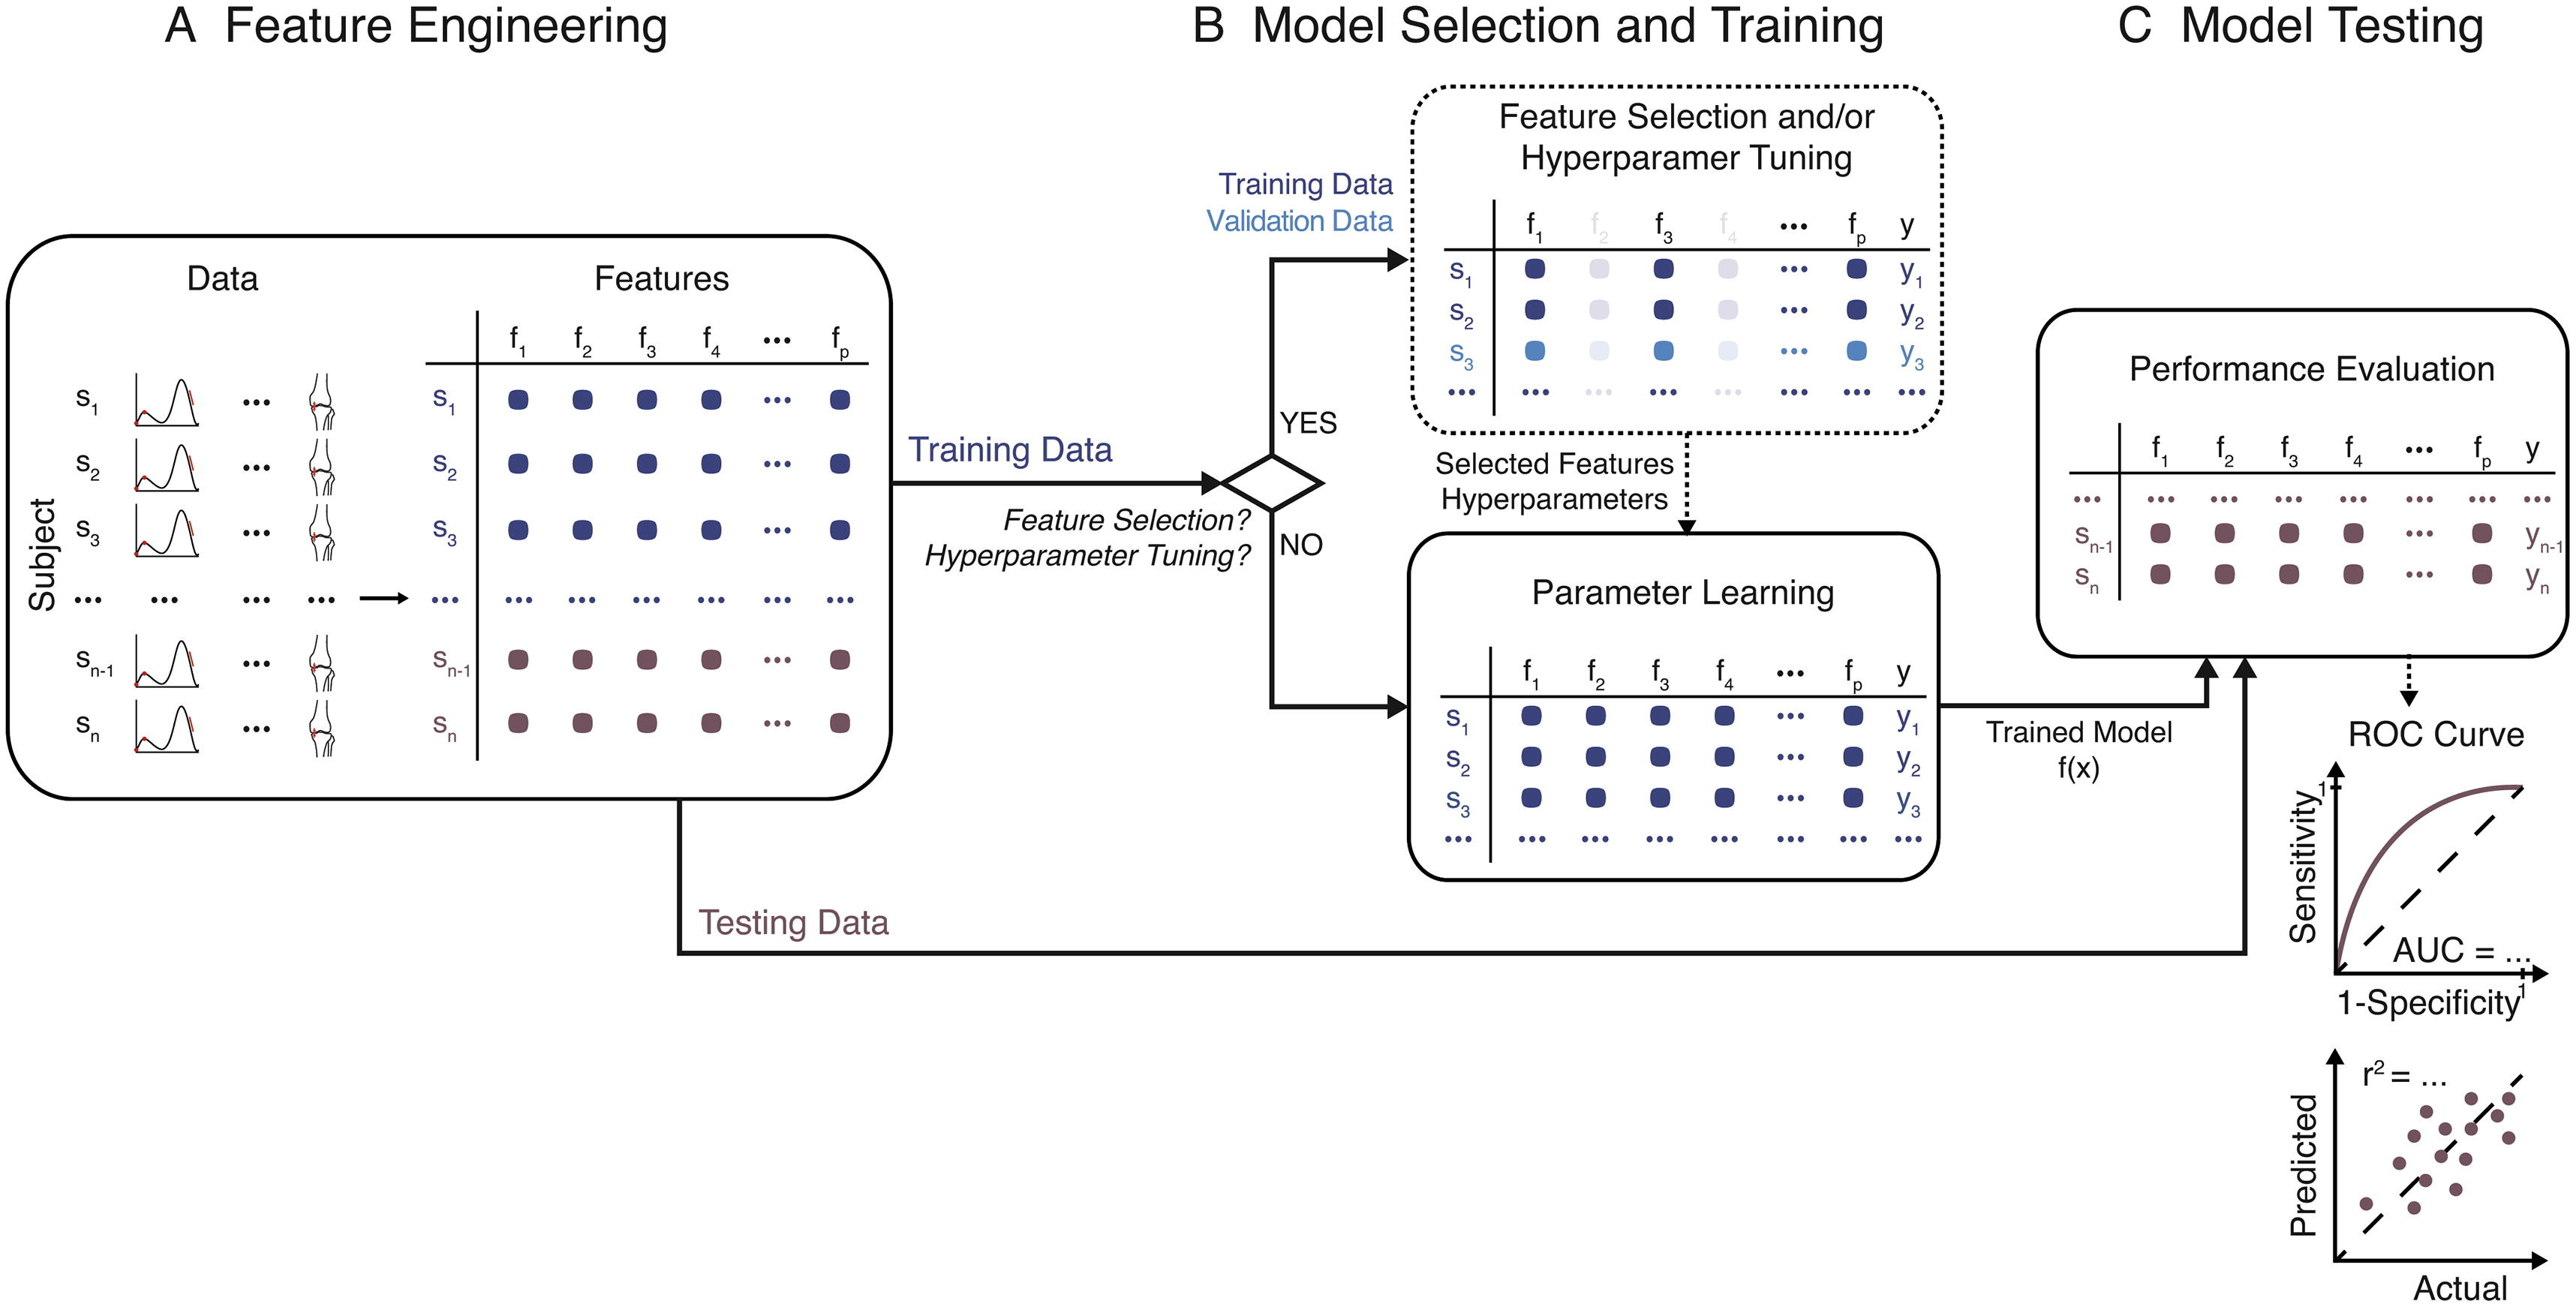

### $Example\; data\; for\; this\; tutorial$

$ This\; dataset\; contains\; 320\; slow\; reaching\; trials\; and\; 320\; fast\; reaching\; trials\; in$
$a\; number\; of\; forward\; and\; backward\; directions$

$The\;initials\;stand\;for\;different\;muscles,\;toggle\; between\; muscles\;below\;to \;inspect\;the\;EMG \;waveform....$

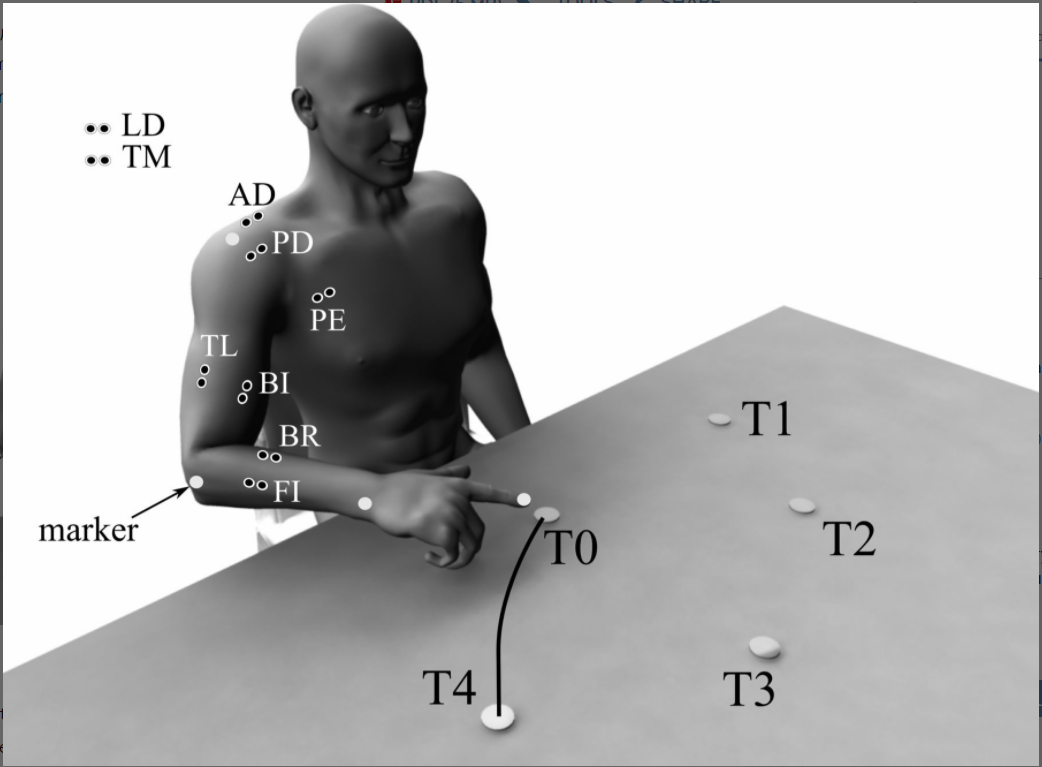

In [3]:
def plot_func(Muscle):

    if Muscle==1.0:
        muscle='FE'
    elif Muscle==2.0:
        muscle='BR'
    elif Muscle==3.0:
        muscle='BI'
    elif Muscle==4.0:
        muscle='PE'
    elif Muscle==5.0:
        muscle='TL'
    elif Muscle==6.0:
        muscle='PD'
    elif Muscle==7.0:
        muscle='AD'
    elif Muscle==8.0:
        muscle='LD'
    else:
        muscle='TM'
    

    m_slow=data[muscle]
    m_slow=m_slow.loc[1:16000]
    m_fast=data[muscle]
    m_fast=m_fast.loc[16001::]
    
    fig, axs = plt.subplots(2,figsize=(15,15),sharey=True)
    fig.suptitle('EMG Waveform for '+muscle)
    axs[0].plot(m_slow,'k--')
    axs[1].plot(m_fast,'k--')
    axs[0].legend('Fast reaching trials')
    axs[1].legend('Slow reaching trials')
    plt.show()

interactive(children=(FloatSlider(value=4.0, description='Muscle', max=9.0, min=1.0, step=1.0), Output()), _do…

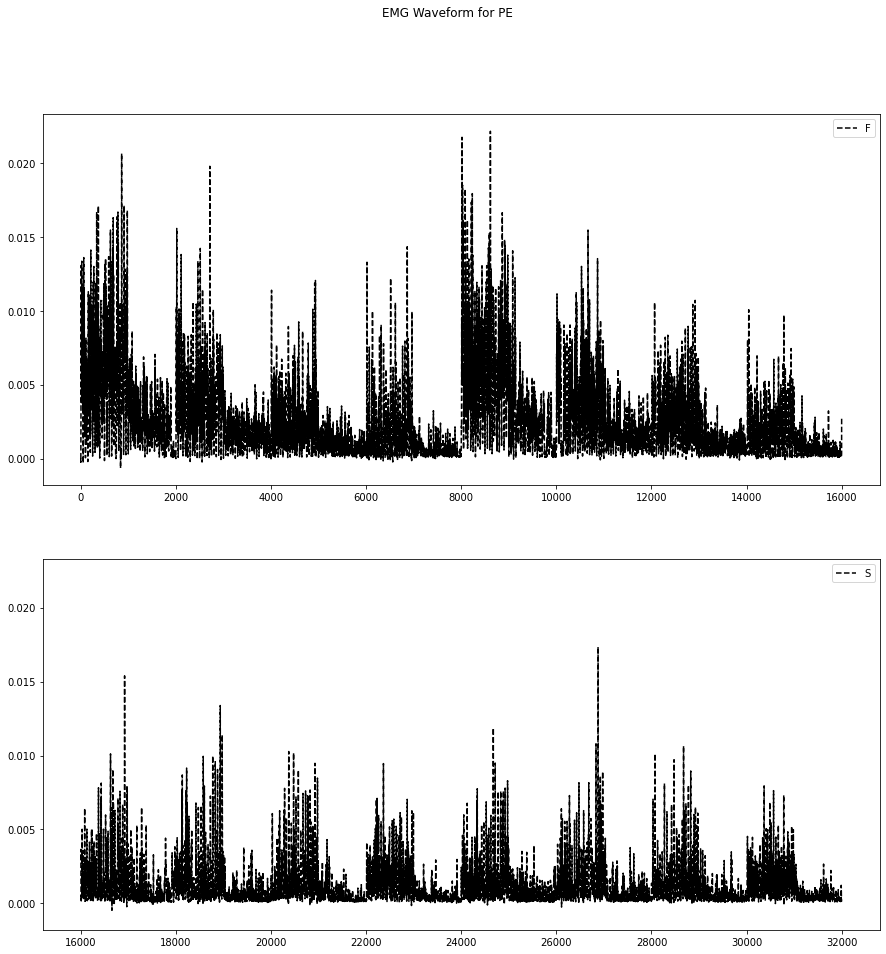

In [4]:

data=pd.read_excel('EMG_dave.xlsx')
task_data=pd.read_excel('trg.xlsx')
widg1=interact(plot_func,Muscle = widgets.FloatSlider(value=4.0,
                                               min=1.0,
                                               max=9.0,
                                               step=1), continuous_update=False)
display(widg1)

$Now, \; select\; the\; type\; and\; number\; of\; trials\; you\;$
$want\; for\; training\; the\; machine-learning\; algorthims\; below$

$Choices\; include:$<br>
    $-Normalization\; by\; maximum\; or\; average\; values$<br>
    $-Fast,\; slow\; or\; both\; speed\; trial\; types$<br>
    $-The\; number\; of\; trials\; you\; would\; like$<br>

In [5]:
def func_data(Speed,Normalization,Trials):
    global trials, taskdata,speed,activations
    trials=Trials
    speed=Speed
    activations=pd.read_excel("acal.xlsx",header=None)

    if Speed==1 and Trials>320:
        print('Maximum number of slow trials available=320, try again...')
        return
    
    if Speed==2 and Trials>320:
        print('Maximum number of fast trials available=320, try again...')
        return
    
    if Normalization==1:
        print('Normalization by maximum values selected...')
        df=pd.read_excel("EMG_daven1.xlsx")
    elif Normalization==2:
        print('Normalization by average values selected...')
        df=pd.read_excel("EMG_daven2.xlsx")
    else:
        print('No normalization procedure selected...')
        df=pd.read_excel('EMG_dave.xlsx')
        
    if Speed==1:
        i = (50 * round(np.rint(Trials*50)/50)+15999)
        print('Slow trials only selected...')
        tasks=df.loc[16000:i,:]
            
    elif Speed==2:
        i = (50 * round(np.rint(Trials*50)/50))-1
        print('Fast trials only selected...')
        
        tasks=df.iloc[0:i,:]
    else:
        print('Both speed trials selected...')
        i = (50 * round(np.rint(Trials*50)/50)/2)-1
        ii = (50 * round(np.rint(Trials*50)/50)/2+15999)
        task_slow=df.loc[0:i,:]
        task_fast=df.loc[16000:ii,:]
        tasks=task_slow.append(task_fast)
    display(tasks)
    
    if Speed==1:
        taskdata=task_data.iloc[0:trials,:]
        activations=activations.iloc[0:trials,:]
    elif Speed==2:
        taskdata=task_data.iloc[320:(trials+320),:]
        activations=activations.iloc[320:(trials+320),:]
    else:
        task_s=task_data.iloc[0:math.ceil((trials/2.0)),:]
        task_f=task_data.iloc[320:math.ceil((trials/2.0)+320),:]
        taskdata=task_s.append(task_f)
        act_s=activations.iloc[0:math.ceil((trials/2.0)),:]
        act_f=activations.iloc[320:math.ceil((trials/2.0)+320),:]
        activations=act_s.append(act_f)
    
    return tasks


In [6]:
widg2=interactive(func_data, 
                   Speed= widgets.IntSlider(value=1,    
                                                   min=1,
                                               max=3,
                                               step=1),
                  Normalization= widgets.IntSlider(value=1,    
                                                   min=1,
                                               max=3,
                                               step=1),
               Trials = widgets.IntSlider(value=320,
                                               min=1,
                                               max=640,
                                               step=1), continuous_update=False)
display(widg2)

interactive(children=(IntSlider(value=1, description='Speed', max=3, min=1), IntSlider(value=1, description='N…

## $Feature\; extraction\; from\; 2nd\; order\; matrices$

$This\; example\; data\; has\; already\; been \;filtered\; and\; pre-processed,\;$<br> 
$so\; we\; are \;ready\; to \;extract \;the\; main\; features....$<br>


$In\; this\; tutorial,\; we\; have\; provided\; three\; algorithms\; to \;explore,\;$<br>
$including\; Non-negative\; matrix\; factorisation,\;Principle\; component \;analysis \; and \;Independent \;component \;analysis$<br>


$Each\; algorithm\; has\; its\; advantages\; and\; limitations\;...compare\; their\; output\;$<br> 
$using\; the\; data\; you\; have\; taken\; in\; the\; previous\; slide$<br>


# $You\; have\; the\; following\; choices\; for\; component\; extraction\; below:$

$algo:\; Choose\; between\; Non-negative\; matrix\; factorisation,\; principal\;or\; component\; analysis$<br>
    
$n_ components:\; Select\; the\; number\; of\; components\; to\; extract\ $<br>


In [7]:
def func_algo(algo,n_components,Type):
    names=widg2.result.columns
    print('Number of components to extract...',n_components)
    if algo==1:
        print('Non-negative matrix factorisation selected...')
        nmf_data=widg2.result
        print (nmf_data.shape)
        model=NMF(n_components=n_components, solver='mu', beta_loss='frobenius', tol=0.0001, 
                  max_iter=200, random_state=None, alpha=0.0, l1_ratio=0.0, 
                  verbose=0, shuffle=False)
        if Type==1:
            print('Spatial synergies selected....')
            
            H=pd.DataFrame(model.fit_transform(abs(nmf_data)).T)
            W=pd.DataFrame(model.components_)
            recon=pd.DataFrame(np.dot(H.T.values,W.values))
            SSE=np.sum(np.linalg.norm((nmf_data.values-recon.values))**2)
            SST=np.sum(np.linalg.norm(nmf_data)**2)
            VAF=1-SSE/SST
            print('Variance accounted for: ',VAF)
            
        else:
            print('Temporal synergies selected....')
            nmf_data=np.reshape(widg2.result.values,[50,trials,9])
            #nmf_data_T=np.transpose(nmf_data,(1,0,2))
            nmf_data_T=np.reshape(nmf_data,[50,trials*9])
            #nmf_data_T=np.transpose(nmf_data)
            
            
            W=pd.DataFrame(model.fit_transform(abs(nmf_data_T)))
            H=pd.DataFrame(model.components_)
            display(W.shape)
            display(H.shape)
            recon=pd.DataFrame(np.reshape(np.dot(W,H),[9,len(widg2.result)]))
            SSE=np.sum(np.linalg.norm((np.reshape(nmf_data,[9,len(widg2.result)])-recon.values))**2)
            SST=np.sum(np.linalg.norm(widg2.result)**2)
            VAF=1-SSE/SST
            print('Variance accounted for: ',VAF)
            
        
        if Type==1:
            
            fig_W, axes_W = plt.subplots(nrows=n_components, ncols=1) 
            fig_W.suptitle('Dimensionality reduction via NNMF ('+str(n_components)+' Spatial W)')
            
            if n_components >1:
                axe_W = axes_W.ravel()
                W=np.array_split(W,n_components)
                
                for k in range(n_components):
                    W[k].T.plot(kind='bar',ax=axe_W[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
                
                
            
            else:    
                
                
                W.T.plot(kind='bar',ax=axes_W,color='k').legend('W',bbox_to_anchor=(1.1, 1.05))
                
            plt.show()
        else:
            
            fig_W, axes_W = plt.subplots(nrows=n_components, ncols=1,sharex=True,figsize=(10,10)) 
            fig_W.suptitle('Dimensionality reduction via NNMF ('+str(n_components)+' Temporal W)')
            
            if n_components >1:
                axe_W = axes_W.ravel()
                
                for k in range(n_components):
                    
                    W[k].T.plot(ax=axe_W[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
                 
                
                
            
            else: 
                W.plot(ax=axes_W,color='k').legend('W',bbox_to_anchor=(1.1, 1.05))
                
            plt.show()
        
    elif algo==2:
        print('Principal component analysis selected...')
        model=PCA(n_components=n_components, 
                  svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
        names=widg2.result.columns
        if Type==1:
            print('Spatial synergies selected...')
            pca_data=widg2.result.T
            pca=pd.DataFrame(model.fit_transform(pca_data))
        else:
            print('Temporal synergies selected...')
            pca_data=widg2.result
            pca_data_T=np.reshape(pca_data.values,[trials,50,9])
            pca_data_T=np.reshape(pca_data_T,[50,trials,9])
            pca_data_T=np.reshape(pca_data_T,[50,trials*9])
            
            
        
        
            pca=pd.DataFrame(model.fit_transform(pca_data_T))
        if Type==1:
            if n_components >1:
                fig, axes = plt.subplots(nrows=n_components, ncols=1,sharex=True,figsize=(10,10)) 
                fig.suptitle('Dimensionality reduction via PCA ('+str(n_components)+' Spatial components)')
            
            
                for k in range(n_components):
        
                    pca.T.iloc[k,:].plot(kind='bar',ax=axes[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
            
                
            else:
                pca.plot(kind='bar',color='k').legend(str(1),bbox_to_anchor=(1.1, 1.05))
            plt.show()
        else:
            if n_components >1:
                fig, axes = plt.subplots(nrows=n_components, ncols=1,sharex=True,figsize=(10,10)) 
                fig.suptitle('Dimensionality reduction via PCA ('+str(n_components)+' Temporal components)')
            
            
                for k in range(n_components):
        
                    pca.T.iloc[k,:].plot(ax=axes[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
            
                
            else:
                
                pca.plot(color='k',figsize=(10,10)).legend(str(1),bbox_to_anchor=(1.1, 1.05))
            plt.show()
    
    else:
        print('Independent component analysis selected...')
        model=FastICA(n_components=n_components)
        if Type==1:
            
            ica_data=widg2.result.T
            ica=pd.DataFrame(model.fit_transform(ica_data))
        else:
            ica_data=widg2.result
            ica_data_T=np.reshape(ica_data.values,[trials,50,9])
            ica_data_T=np.reshape(ica_data_T,[50,trials,9])
            ica_data_T=np.reshape(ica_data_T,[50,trials*9])
            ica=pd.DataFrame(model.fit_transform(ica_data_T))
            
        if Type==1:
            if n_components >1:
                fig, axes = plt.subplots(nrows=n_components, ncols=1,sharex=True,figsize=(10,10)) 
                fig.suptitle('Dimensionality reduction via ICA ('+str(n_components)+' Spatial components)')
            
            
                for k in range(n_components):
        
                    ica.T.iloc[k,:].plot(kind='bar',ax=axes[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
            
                
            else:
                ica.plot(kind='bar',color='k',figsize=(10,10)).legend(str(1),bbox_to_anchor=(1.1, 1.05))
            plt.show()  
        else:
            if n_components >1:
                fig, axes = plt.subplots(nrows=n_components, ncols=1,sharex=True,figsize=(10,10)) 
                fig.suptitle('Dimensionality reduction via ICA ('+str(n_components)+' Temporal components)')
            
            
                for k in range(n_components):
        
                    ica.T.iloc[k,:].plot(ax=axes[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
            
                
            else:
                ica.plot(color='k',figsize=(10,10)).legend(str(1),bbox_to_anchor=(1.1, 1.05))
            plt.show()

interactive(children=(IntSlider(value=1, description='algo', max=3, min=1), IntSlider(value=1, description='n_…

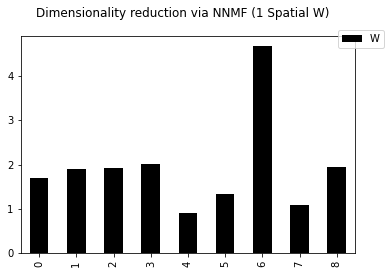

In [8]:

widg3=interactive(func_algo, algo= widgets.IntSlider(value=1,
                                               min=1,
                                               max=3,
                                               step=1),
                   n_components= widgets.IntSlider(value=1,    
                                                   min=1,
                                               max=9,
                                               step=1),
                  Type=widgets.IntSlider(value=1,min=1,max=2,step=1),
                                      continuous_update=False)

display(widg3)

## $Feature\; extraction\; on\; 3rd\; order\; matrices$

$Now\; turning\; to\; tensors,\; below\; you\; can\; toggle\; between\; Tucker,\; non-negative\; Tucker\; and$<br>
$Parafac\; decompositions.\; These\; tensor\; decompositions\; have\; several\; advantages\; over\; classical\; matrix\; factorisations\; including$<br>
$compactness,\; uniqueness\; of\; decomposition,\; and\; generality\; of\; the\; identified\; components.$<br> 

$Extract\; a\; set\; of\; spatial\; and\; temporal\; synergies\; that\; you \;consider\; representative\; of\; the\; dataset....$

In [9]:
def func_tensor(algo,Spatial_components,Temporal_components):
    global spatials, temporals, n_component
    n_component=Spatial_components
    #names=widg2.result.columns
    
    
    data_S=np.reshape(widg2.result.values,[trials,50,9])
    data_T=np.reshape(data_S,[trials,9,50])
    tensor_S=tl.tensor(data_S)
    tensor_T=tl.tensor(data_T)
    
    if algo==1:
        
        ('Tucker tensor decomposition selected...')
        print('Number of Spatial components to extract...',Spatial_components)
        print('Number of Temporal components to extract...',Temporal_components)
        core_S, factors_S = tucker(tensor_S ,rank=max(Spatial_components,Temporal_components))
        #core_T, factors_T = tucker(tensor_T ,rank=Temporal_components)
        tensor_recon_S=tucker_to_tensor([core_S, factors_S])
        #tensor_recon_T=tucker_to_tensor([core_T, factors_T])
        
        SSE=np.sum(np.linalg.norm((tensor_S-tensor_recon_S))**2)
        SST=np.sum(np.linalg.norm(tensor_S)**2)
        VAF=1-SSE/SST
        print('Variance accounted for: ',VAF)
        #SSE=np.sum(np.linalg.norm((tensor_T-tensor_recon_T))**2)
        #SST=np.sum(np.linalg.norm(tensor_T)**2)
        #VAF=1-SSE/SST
        #print('Temporal variance accounted for: ',VAF)
        
        activations=pd.DataFrame(factors_S[0])
        temporals=factors_S[1]
        spatials=factors_S[2]

        fig_W, axes_W = plt.subplots(nrows=Spatial_components, ncols=1,sharex=True,figsize=(10,5)) 
        fig_W.suptitle('Tucker tensor decomposition into ('+str(Spatial_components)+' Spatial synergies)')
        fig_H, axes_H = plt.subplots(nrows=Temporal_components, ncols=1,sharex=True,figsize=(10,5)) 
        fig_H.suptitle('Tucker tensor decomposition into ('+str(Temporal_components)+' Temporal synergies)')
        W=pd.DataFrame(factors_S[2])
        H=pd.DataFrame(factors_S[1])
        
        
        if Spatial_components >=2:
        
                
            for k in range(Spatial_components):
                W.iloc[:,k].plot(kind='bar',ax=axes_W[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))     
                
        else:
            W.plot(kind='bar',ax=axes_W,color='k').legend('W',bbox_to_anchor=(1.1, 1.05))
        
        if Temporal_components >=2:    
            for k in range(Temporal_components):
                H.iloc[:,k].plot(kind='line',ax=axes_H[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
                
        
        else:
            H.plot(kind='line',ax=axes_H,color='k').legend('H',bbox_to_anchor=(1.1, 1.05))
        plt.show()

            
    elif algo==2:
        print('Non-negative tucker tensor decomposition selected...')
        print('Number of Spatial components to extract...',Spatial_components)
        print('Number of Temporal components to extract...',Temporal_components)
        core_S, factors_S = non_negative_tucker(tensor_S ,rank=max(Spatial_components,Temporal_components))
        #core_T, factors_T = non_negative_tucker(tensor_T ,rank=Temporal_components)
        tensor_recon_S=tucker_to_tensor([core_S, factors_S])
        #tensor_recon_T=tucker_to_tensor([core_T, factors_T])
        
        SSE=np.sum(np.linalg.norm((tensor_S-tensor_recon_S))**2)
        SST=np.sum(np.linalg.norm(tensor_S)**2)
        VAF=1-SSE/SST
        print('Variance accounted for: ',VAF)
        #SSE=np.sum(np.linalg.norm((tensor_T-tensor_recon_T))**2)
        #SST=np.sum(np.linalg.norm(tensor_T)**2)
        #VAF=1-SSE/SST
        #print('Temporal variance accounted for: ',VAF)
        activations=pd.DataFrame(factors_S[0])
        temporals=factors_S[1]
        spatials=factors_S[2]

        fig_W, axes_W = plt.subplots(nrows=Spatial_components, ncols=1,sharex=True,figsize=(10,5)) 
        fig_W.suptitle('Non-negative Tucker tensor decomposition into ('+str(Spatial_components)+' Spatial synergies)')
        fig_H, axes_H = plt.subplots(nrows=Temporal_components, ncols=1,sharex=True,figsize=(10,5)) 
        fig_H.suptitle('Non-negative Tucker tensor decomposition into ('+str(Temporal_components)+' Temporal synergies)')
        W=pd.DataFrame(factors_S[2])
        H=pd.DataFrame(factors_S[1])
        
        if Spatial_components >1:
        
                
            for k in range(Spatial_components):
                W.iloc[:,k].plot(kind='bar',ax=axes_W[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))     
            
        else:
            W.plot(kind='bar',ax=axes_W,color='k').legend('W',bbox_to_anchor=(1.1, 1.05))
        
        if Temporal_components >1:    
            for k in range(Temporal_components):
                H.iloc[:,k].plot(kind='line',ax=axes_H[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
            
        
        else:    
        
            H.plot(kind='line',ax=axes_H,color='k').legend('H',bbox_to_anchor=(1.1, 1.05))
        plt.show()
        
    elif algo==3:
        print('Parafac tensor decomposition selected...')
        print('Number of components to extract...',Spatial_components)
        Temporal_components=Spatial_components
        #print('Number of Temporal components to extract...',Temporal_components)
        core_S, factors_S = parafac(tensor_S ,rank=Spatial_components)
        #core_T, factors_T = parafac(tensor_T ,rank=Temporal_components)
        tensor_recon_S=cp_to_tensor([core_S, factors_S])
        #tensor_recon_T=cp_to_tensor([core_T, factors_T])
        SSE=np.sum(np.linalg.norm((tensor_S-tensor_recon_S))**2)
        SST=np.sum(np.linalg.norm(tensor_S)**2)
        VAF=1-SSE/SST
        print('Variance accounted for: ',VAF)
        #SSE=np.sum(np.linalg.norm((tensor_T-tensor_recon_T))**2)
        #SST=np.sum(np.linalg.norm(tensor_T)**2)
        #VAF=1-SSE/SST
        #print('Temporal Variance accounted for: ',VAF)
        activations=pd.DataFrame(factors_S[0])
        temporals=factors_S[1]
        spatials=factors_S[2]

        fig_W, axes_W = plt.subplots(nrows=Spatial_components, ncols=1,sharex=True,figsize=(10,5)) 
        fig_W.suptitle('Parafac decomposition into ('+str(n_component)+' Spatial synergies)')
        fig_H, axes_H = plt.subplots(nrows=Temporal_components, ncols=1,sharex=True,figsize=(10,5)) 
        fig_H.suptitle('Parafac decomposition into ('+str(n_component)+' Temporal synergies)')
        W=pd.DataFrame(factors_S[2])
        H=pd.DataFrame(factors_S[1])
    
        if Spatial_components >1:
        
                
            for k in range(Spatial_components):
                W.iloc[:,k].plot(kind='bar',ax=axes_W[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
            
        else:
            W.plot(kind='bar',ax=axes_W,color='k').legend('S',bbox_to_anchor=(1.1, 1.05))
            
        if Temporal_components >1:   
            
            
            for k in range(Temporal_components):
                H.iloc[:,k].plot(kind='line',ax=axes_H[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
            
        
        else:    
        
            H.plot(kind='line',ax=axes_H,color='k').legend('T',bbox_to_anchor=(1.1, 1.05))
         
        plt.show()
        
    else:
        print('Non-negative Parafac tensor decomposition selected...')
        print('Number of Spatial components to extract...',Spatial_components)
        Temporal_components=Spatial_components
        #print('Number of Temporal components to extract...',Temporal_components)
        core_S, factors_S = non_negative_parafac(tensor_S ,rank=Spatial_components)
        #core_T, factors_T = non_negative_parafac(tensor_T ,rank=Temporal_components)
        tensor_recon_S=cp_to_tensor([core_S, factors_S])
        #tensor_recon_T=cp_to_tensor([core_T, factors_T])
        SSE=np.sum(np.linalg.norm((tensor_S-tensor_recon_S))**2)
        SST=np.sum(np.linalg.norm(tensor_S)**2)
        VAF=1-SSE/SST
        print('Spatial Variance accounted for: ',VAF)
        #SSE=np.sum(np.linalg.norm((tensor_T-tensor_recon_T))**2)
        #SST=np.sum(np.linalg.norm(tensor_T)**2)
        #VAF=1-SSE/SST
        #print('Temporal Variance accounted for: ',VAF)
        activations=pd.DataFrame(factors_S[0])
        temporals=factors_S[1]
        spatials=factors_S[2]

        fig_W, axes_W = plt.subplots(nrows=Spatial_components, ncols=1,sharex=True,figsize=(10,5)) 
        fig_W.suptitle('Non-negative Parafac decomposition into ('+str(Spatial_components)+' Spatial synergies)')
        fig_H, axes_H = plt.subplots(nrows=Temporal_components, ncols=1,sharex=True,figsize=(10,5)) 
        fig_H.suptitle('Non-negative Parafac decomposition into ('+str(Temporal_components)+' Temporal synergies)')
        W=pd.DataFrame(factors_S[2])
        H=pd.DataFrame(factors_S[1])
    
        if Spatial_components >1:
        
                
            for k in range(Spatial_components):
                W.iloc[:,k].plot(kind='bar',ax=axes_W[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))     
            
        else:
            W.plot(kind='bar',ax=axes_W,color='k').legend('S',bbox_to_anchor=(1.1, 1.05))
        
        if Temporal_components >1:    
            for k in range(Temporal_components):
                H.iloc[:,k].plot(kind='line',ax=axes_H[k],color='k').legend(str(k+1),bbox_to_anchor=(1.1, 1.05))
            
        
        else:    
        
            H.plot(kind='line',ax=axes_H,color='k').legend('T',bbox_to_anchor=(1.1, 1.05))
        plt.show()

interactive(children=(IntSlider(value=1, description='algo', max=4, min=1), IntSlider(value=1, description='Sp…

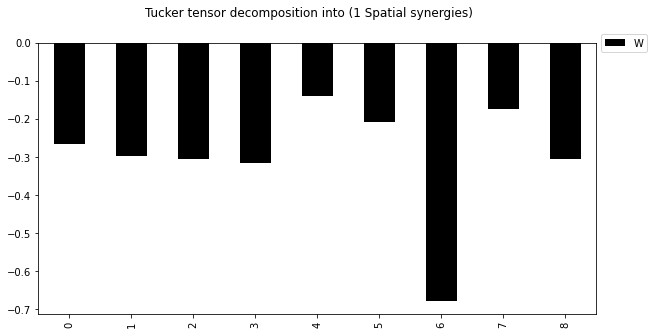

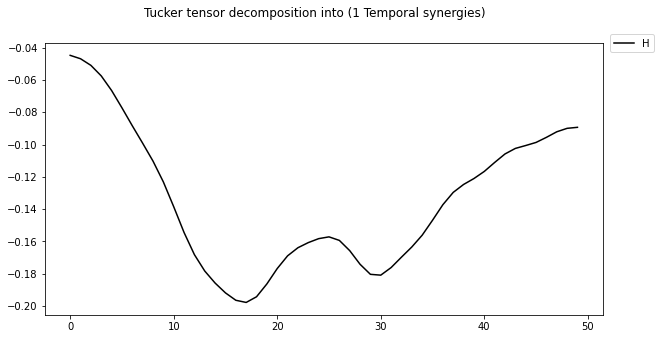

In [10]:
widg_tensor=interactive(func_tensor,algo=widgets.IntSlider(value=1,min=1,max=4,step=1),
                   Spatial_components= widgets.IntSlider(value=1,    
                                                   min=1,
                                               max=9,
                                               step=1),
                      Temporal_components= widgets.IntSlider(value=1,    
                                                   min=1,
                                               max=9,
                                               step=1),
                                      continuous_update=False)

display(widg_tensor)

In [11]:
def func_class_reaching(Algorithm,Components,Task,train_size,Kernel,Neighbors):
    x=activations.iloc[:,0:Components]
    
    if speed==1 & Task==2:  
        print('Single speed trials selected previously, to use speed as a dependent variable select both trials...')
        return
    elif speed==2 & Task==2:
        print('Single speed trials selected previously, to use speed as a dependent variable select both trials...')
        return
    else:
        
        
        if Task==1:
            task=taskdata.iloc[:,0]
            print('Reaching-task dependent variable selected...')
        elif Task==2:
            task=taskdata.iloc[:,1]
            print('Reaching-speed dependent variable selected...')
        elif Task==3:
            task=taskdata.iloc[:,2]
            print('Reaching-direction dependent variable selected...')
        
        X_train, X_test, y_train, y_test=train_test_split(x.values,task.values,train_size=train_size,stratify=task.values)
    
        if Algorithm==1:
            
            print('Support vector machines selected...')
            if Kernel==1:
                print('Linear kernel selected...')
                model=SVC(kernel='linear',random_state=42)
            elif Kernel==2:
                print('rbf kernel selected...')
                model=SVC(kernel='rbf',random_state=42)
            elif Kernel==3:
                print('Poly kernel selected...')
                model=SVC(kernel='poly',random_state=42)
            else:
                print('Sigmoid kernel selected...')
                model=SVC(kernel='sigmoid',random_state=42)
            model.fit(X_train,y_train)
            y_pred=model.predict(X_test)
            print('Accuracy score: ',accuracy_score(y_test,y_pred))
            plot_confusion_matrix(model,X_test,y_test)
            plt.show()
            #cm = confusion_matrix(y_test, y_pred, labels=task.values)
            #disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=task.values)
            #disp.plot() 
        
        elif Algorithm==2:
            print('K-Nearest neighbors selected')
            print('Number of neighbors selected: ', Neighbors)
            model=KNN(n_neighbors=Neighbors)
            model.fit(X_train,y_train)
            y_pred=model.predict(X_test)
            print('Accuracy score: ',accuracy_score(y_test,y_pred))
            plot_confusion_matrix(model,X_test,y_test)
            plt.show()
            #cm = confusion_matrix(y_test, y_pred, labels=task.values)
            #disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=task.values)
            #disp.plot() 
            
        else:
            print('Linear discriminant analysis selected...')
            model=LDA()
            model.fit(X_train,y_train)
            y_pred=model.predict(X_test)
            print('Accuracy score: ',accuracy_score(y_test,y_pred))
            plot_confusion_matrix(model,X_test,y_test)
            plt.show()
            #cm = confusion_matrix(y_test, y_pred, labels=task.values)
            #disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=task.values)
            #disp.plot() 
            

In [12]:
widg6=interact(func_class_reaching,
               Algorithm=widgets.IntSlider(value=3,min=1,max=3,step=1),
               Components=widgets.IntSlider(value=12,min=1,max=12,step=1),
               Task=widgets.IntSlider(value=1,min=1,max=3,step=1),
               train_size=widgets.FloatSlider(value=0.8,min=0.1,max=1.0,step=0.01),
               Kernel=widgets.IntSlider(value=1,min=1,max=4,step=1),
               Neighbors=widgets.IntSlider(value=5,min=1,max=25,step=1),
                                      continuous_update=False)
    

interactive(children=(IntSlider(value=3, description='Algorithm', max=3, min=1), IntSlider(value=12, descripti…

In [ ]:
pyautogui.hotkey('f5')

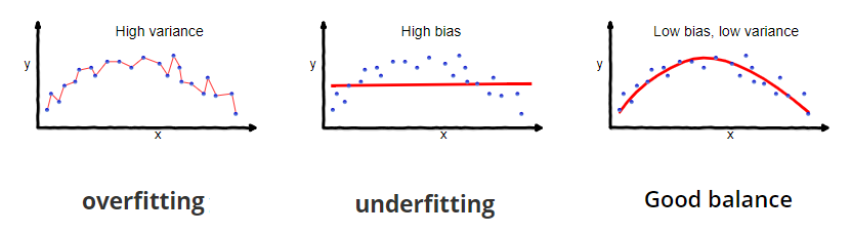

$References$

Halilaj, E., Rajagopal, A., Fiterau, M., Hicks, J. L., Hastie, T. J., & Delp, S. L. (2018). Machine learning in human movement biomechanics: Best practices, common pitfalls, and new opportunities. Journal of biomechanics, 81, 1–11. https://doi.org/10.1016/j.jbiomech.2018.09.009

Zago, M., Kleiner, A. F. R., & Federolf, P. A. (2020). Machine Learning Approaches to Human Movement Analysis. Frontiers in Bioengineering and Biotechnology, 8, 1573.

Alessandro, C., Delis, I., Nori, F., Panzeri, S., & Berret, B. (2013). Muscle synergies in neuroscience and robotics: from input-space to task-space perspectives. Frontiers in computational neuroscience, 7, 43.

Phinyomark, A., Petri, G., Ibáñez-Marcelo, E. et al. Analysis of Big Data in Gait Biomechanics: Current Trends and Future Directions. J. Med. Biol. Eng. 38, 244–260 (2018). https://doi.org/10.1007/s40846-017-0297-2

Rozumalski, A., & Schwartz, M. H. (2009). Crouch gait patterns defined using k-means cluster analysis are related to underlying clinical pathology. Gait & posture, 30(2), 155-160.

